1. x Benchmark Events
-  x Auswahleverteilung iN und hN darstellen für val, Validation und Test daten
2. x RMSE, MSE und MAE für val, Val und Test vergleichen
3. x Verteilung für alle ergebnisse
- Boxplot oder Violinenplot
-> schein nicht viel sinn zu machen, da zu viele datenpunkte
4. x Actual vs Fitted
5. x (evtl Residuals vs Fitted) könnte nützlich sein um zu schauen bei welchen Wertebereichen welche tendenz besteht
5. MSE der Maximalwerte jedes Ereignisses aus Testdatensatz
- (Zeitliche Verschiebung des Maximalwertes)
6. x Stichproben Plots von Maximalwerten 


In [2]:

# Load Relevant Libraries, the model and the test data
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np
import pandas as pd
from tensorflow.keras.models import model_from_json
import joblib
import pickle
import os
import seaborn as sns
from modules.sequence_and_normalize import sequence_data, sequence_sample_random, sequence_list
from sklearn.preprocessing import MinMaxScaler
from modules.plots import plot_seq_i_d_Q
from modules.save_load_model import load_model
from modules.predict_and_prepare import pred_inverse_all
from modules.eval_helpers import rmse_from_raw, mae_from_raw


# Load the model
model_name = 'Gievenbeck_Deep_LSTM_Single_1h_P_20240418'
model_folder = os.path.join('05_models', model_name)
# model_folder = os.path.join('05_models', 'Gievenbeck_SingleNode_LSTM_20240328')
model, in_scaler, out_scaler, train_data, val_data, test_data, data_info_dict = load_model(model_folder)



2024-04-18 17:36:41.515608: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-18 17:36:42.159966: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-04-18 17:36:42.978423: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-18 17:36:43.008465: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-18 17:36:43.008548: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] co

Loaded model from disk


In [3]:
# Load events data
# events_df = pd.read_csv('02_input_data/events_FMO.csv')

# sequence data to list structure
lag = data_info_dict['lag']
delay = data_info_dict['delay']
p_steps = data_info_dict['prediction_steps']

in_vars= data_info_dict['in_vars']
out_vars= data_info_dict['out_vars']

seq_test, seq_test_trans = sequence_list(test_data, in_vars=in_vars, out_vars=out_vars, in_scaler=in_scaler, 
                                  out_scaler=out_scaler, lag=lag, delay=delay, prediction_steps=p_steps)

train_true, train_pred = pred_inverse_all(train_data, model, in_vars, out_vars, in_scaler, out_scaler, lag, delay, p_steps)
val_true, val_pred = pred_inverse_all(val_data, model, in_vars, out_vars, in_scaler, out_scaler, lag, delay, p_steps)
test_true, test_pred = pred_inverse_all(test_data, model, in_vars, out_vars, in_scaler, out_scaler, lag, delay, p_steps)

train_resid = train_true - train_pred
val_resid = val_true - val_pred
test_resid = test_true - test_pred
train_resid = train_resid.flatten()
val_resid = val_resid.flatten()
test_resid = test_resid.flatten()

I0000 00:00:1713454610.072607    6775 service.cc:145] XLA service 0x7faac4004340 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1713454610.072655    6775 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Laptop GPU, Compute Capability 8.6
2024-04-18 17:36:50.083491: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-18 17:36:50.142807: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8904


 80/595 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

I0000 00:00:1713454610.550438    6775 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


595/595 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [4]:
# Print all Event meta data 
# i=0
# for obj in seq_test_trans:
#     print(i, obj[0])
#     i += 1


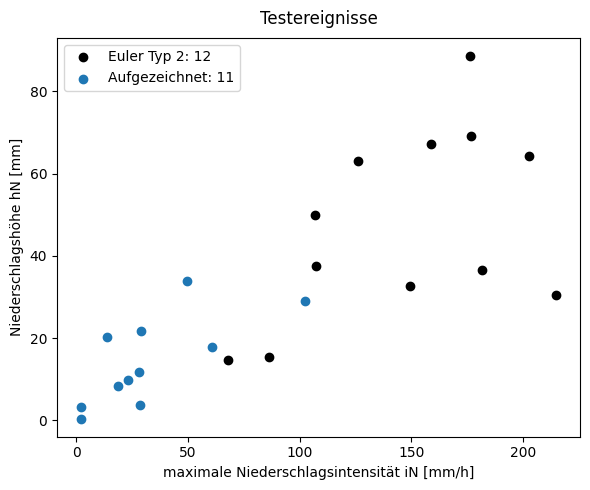

In [5]:
# Extract total precipitation and max intensity from seq_test
e2_precipitation = [obj[0]['total precipitation'] for obj in seq_test_trans if obj[0]['event type'] == 'Euler Typ 2']
e2_intensity = [obj[0]['max intensity'] for obj in seq_test_trans if obj[0]['event type'] == 'Euler Typ 2']

aufgezeichnet_precipitation = [obj[0]['total precipitation'] for obj in seq_test_trans if obj[0]['event type'] == 'Aufgezeichnet']
aufgezeichnet_intensity = [obj[0]['max intensity'] for obj in seq_test_trans if obj[0]['event type'] == 'Aufgezeichnet']

# Plot events precipitation and intensity in scatterplot
fig, ax2 = plt.subplots(figsize=(6, 5))
ax2.plot( e2_intensity, e2_precipitation,'o', color='black', label='Sample')
ax2.scatter(aufgezeichnet_intensity, aufgezeichnet_precipitation, marker='o',  label='Events')
ax2.set_xlabel('maximale Niederschlagsintensität iN [mm/h]')
ax2.set_ylabel('Niederschlagshöhe hN [mm]')
ax2.set_title('Testereignisse', pad=10)
ax2.legend(labels=['Euler Typ 2: {}'.format(len(e2_precipitation)), 'Aufgezeichnet: {}'.format(len(aufgezeichnet_precipitation))])
plt.tight_layout()


In [6]:
# in_col=1
# out_col=2
# # Keep track of original shapes of in and out data
# in_original_shape = [sample[in_col].shape for sample in seq_test]  
# in_concat = np.concatenate([np.array(sample[in_col]) for sample in seq_test])
# in_concat = np.concatenate([np.array(sequence) for sequence in in_concat])
# # in_concat_flattened = np.reshape(in_concat, (in_concat.shape[0], -1, in_concat.shape[2]))

# out_original_shape = [sample[out_col].shape for sample in seq_test]

# out_concat = np.concatenate([sample[2].reshape(sample[2].shape[0], -1) for sample in seq_test])

# # out_concat = np.concatenate([np.array(sample[out_col]) for sample in seq_test])

# print(in_concat)

# in_invert = in_scaler.inverse_transform(in_concat)
# out_invert = out_scaler.inverse_transform(out_concat)



In [7]:
# # Reshape in_concat back to original shape
# in_invert = np.split(in_concat, np.cumsum([np.prod(shape) for shape in in_original_shape[:-1]]))
# in_invert = [sample.reshape(shape) for sample, shape in zip(in_invert, in_original_shape)]


# # Reshape out_concat back to original shape
# out_invert = np.split(out_concat, np.cumsum([np.prod(shape) for shape in out_original_shape[:-1]]))
# out_invert = [sample.reshape(shape) for sample, shape in zip(out_invert, out_original_shape)]

# seq_test_invert = [(seq_test[i][0], in_invert[i], out_invert[i]) for i in range(len(seq_test))]

# # # Check if the sum of the columns is the same to verify reshaping works properly
# # col_1_sum_seq_test_invert = sum([np.sum(sample[1]) for sample in seq_test_invert])
# # col_1_sum_seq_test = sum([np.sum(sample[1]) for sample in seq_test])
# # col_2_sum_seq_test_invert = sum([np.sum(sample[2]) for sample in seq_test_invert])
# # col_2_sum_seq_test = sum([np.sum(sample[2]) for sample in seq_test])
# # is_same_sum = col_1_sum_seq_test_invert == col_1_sum_seq_test
# # is_same_sum_2 = col_2_sum_seq_test_invert == col_2_sum_seq_test
# # print(is_same_sum, is_same_sum_2)


595/595 ━━━━━━━━━━━━━━━━━━━━ 1s 997us/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
[0.06664678 0.06329341 0.07398482]


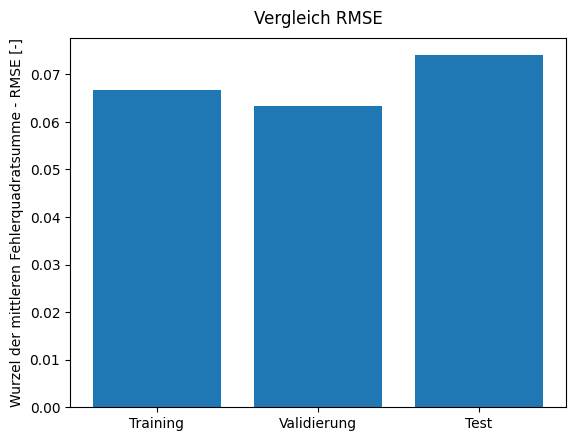

In [8]:
rmse = rmse_from_raw([train_data, val_data, test_data], model, in_vars, out_vars, in_scaler, out_scaler, lag, delay, p_steps)
print(rmse)
# Bar plot
plt.title('Vergleich RMSE', pad=10)
plt.bar(['Training', 'Validierung', 'Test'], rmse)
plt.ylabel('Wurzel der mittleren Fehlerquadratsumme - RMSE [-]')

# Show the plot
plt.show()

595/595 ━━━━━━━━━━━━━━━━━━━━ 1s 863us/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
[0.00375167 0.00323815 0.00562214]


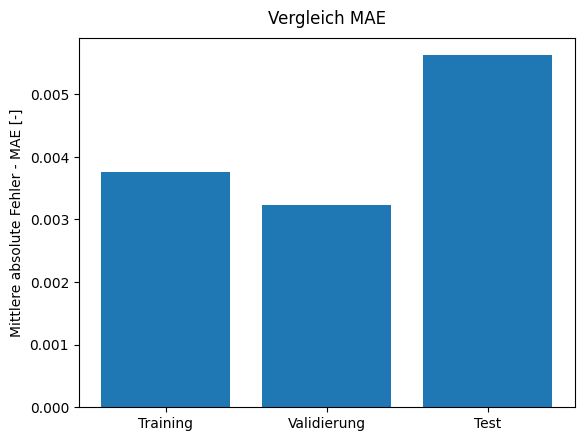

In [9]:
mae = mae_from_raw([train_data, val_data, test_data], model, in_vars, out_vars, in_scaler, out_scaler, lag, delay, p_steps)
print(mae)
# Bar plot
plt.title('Vergleich MAE', pad=10)
plt.bar(['Training', 'Validierung', 'Test'], mae)
plt.ylabel('Mittlere absolute Fehler - MAE [-]')

# Show the plot
plt.show()

- Density plot - abhängigkeit von input daten wird hier wahrscheinlich weniger sichtbar
- 

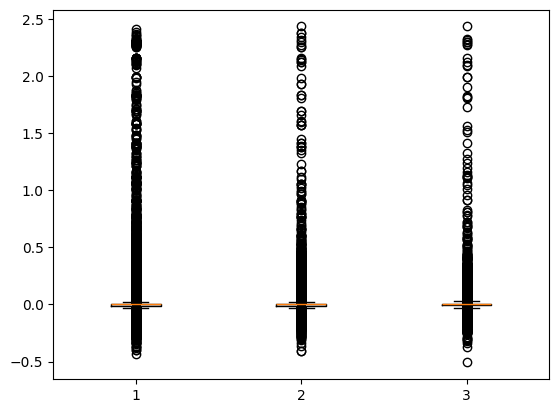

In [10]:

resid = [train_resid, val_resid, test_resid]

plt.boxplot(resid)

# Display the plot
plt.show()

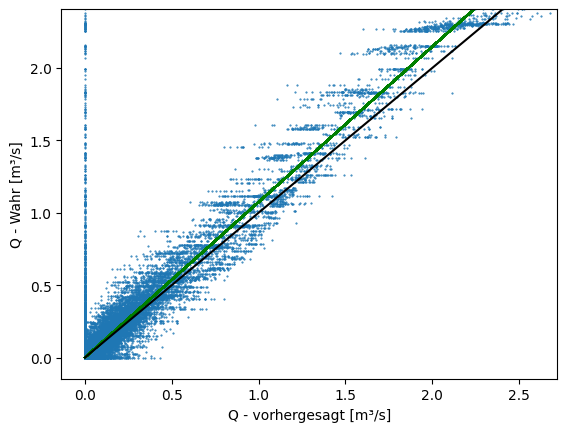

In [13]:
# Flatten the data
train_pred_flat = train_pred.flatten()
train_true_flat = train_true.flatten()

# Plot the data
plt.plot(train_pred_flat, train_true_flat, '.', markersize=1,  label='Train')

# Fit a line to the data
slope, intercept = np.polyfit(train_pred_flat, train_true_flat, 1)

# Plot the fitted line
plt.plot(train_pred_flat, slope * train_pred_flat + intercept, color='green')

# Set the upper limit of the y-axis to the maximum value of each variable
plt.ylim(None, max(train_true_flat))
plt.xlim(None, max(train_pred_flat))
# Draw a line with incline of 1
plt.plot([0, max(train_true_flat)], [0, max(train_true_flat)], color='black')

plt.xlabel('Q - vorhergesagt [m³/s]')
plt.ylabel('Q - Wahr [m³/s]')
plt.show()

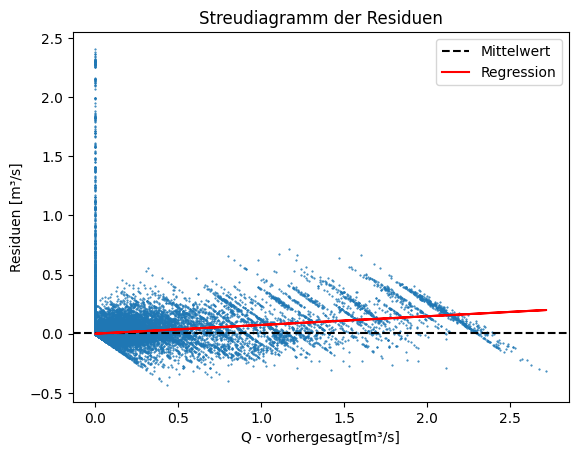

In [14]:

# Calculate the average line
avg_line = np.mean(train_resid)

# Calculate the regression line using polynomial fit
reg_line = np.polyfit(train_pred_flat, train_resid, 1)
reg_line_fn = np.poly1d(reg_line)

# Create the scatter plot
plt.plot(train_pred_flat, train_resid, '.', markersize=1)

# Plot the average line
plt.axhline(avg_line, color='black', linestyle='--', label='Mittelwert')

# Plot the regression line
plt.plot(train_pred_flat, reg_line_fn(train_pred_flat), color='red', label='Regression')

# Set the labels and title
plt.xlabel('Q - vorhergesagt[m³/s]')
plt.ylabel('Residuen [m³/s]')
plt.title('Streudiagramm der Residuen')

# Add a legend
plt.legend()

# Show the plot
plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


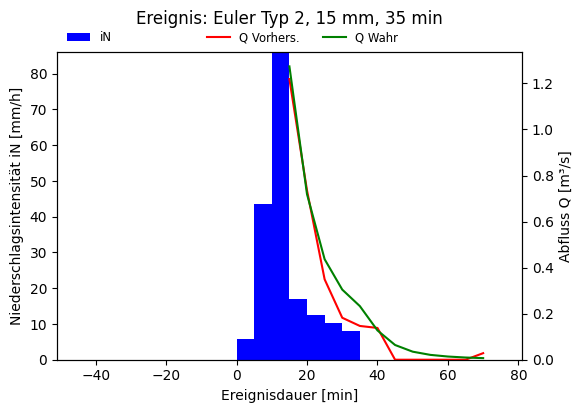

In [15]:
# test for plot_seq_i_d_Q function
n_sample = 3
n = 15
interval = seq_test[n_sample][0]['interval']
meta = seq_test[n_sample][0]
in_seq = seq_test[n_sample][1][n]
out_act = seq_test[n_sample][2][n]

# Calculate the start and end time of the sequence so that a duration column can be created
start_time = max(seq_test[n_sample][1][n][:, 0]) + interval + delay * interval
end_time = start_time + p_steps * interval
duration_col = np.arange(start_time, end_time, interval)

Predict = model.predict(seq_test_trans[n_sample][1])
Predict_invert = out_scaler.inverse_transform(Predict)

predict_seq = np.column_stack((duration_col,Predict_invert[n]))
actual_seq = np.column_stack((duration_col,out_act))


plot_seq_i_d_Q(in_seq, actual_seq, predict_seq, meta, interval,).show()

In [11]:
len(seq_test[3][1]) * 5 - 240
# max_index

30

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


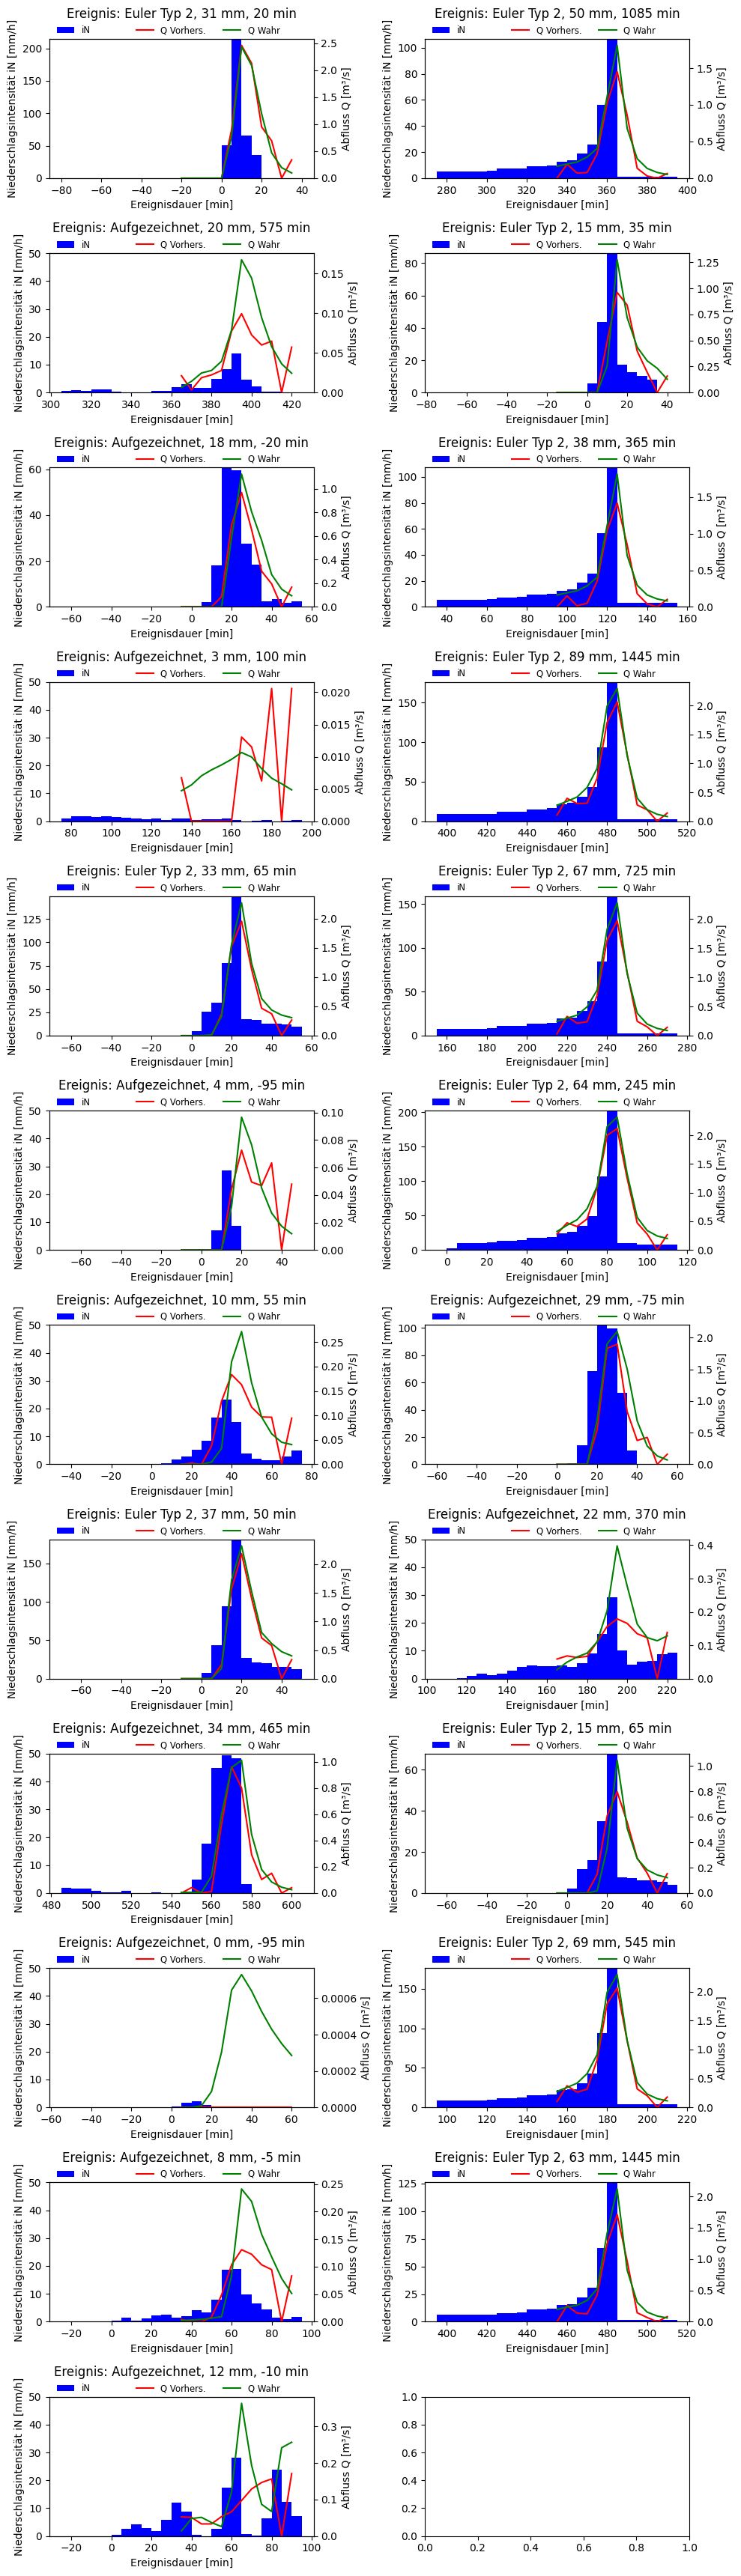

In [16]:
# make this a function that takes event_data =seq_test[n_sample], event_data_trans, n_seq = n,  interval, delay, p_steps, duration_col

# Specify what the column index of the duration data in the input data is
# duration_col = int(0)
#retrieve the interval of the time steps
interval = seq_test[0][0]['interval']  

# Create a grid of subplots
plot_rows = int(len(seq_test_trans)/2+1)
fig, axs = plt.subplots(plot_rows, 2, figsize=(10, 1.5*len(seq_test_trans)))

# Loop through n_sample
for n_sample in range(len(seq_test_trans)):
    # n = 12 +int((len(seq_test[n_sample][1])-24) / 3)
    # n = int(len(seq_test[n_sample][1]) / 5)
    n = np.argmax(seq_test[n_sample][2][:, 0, 0])
    n = n - p_steps/2
    n = n.astype(int)

    # Calculate the start and end time of the sequence so that a duration column can be created
    start_time = max(seq_test[n_sample][1][n][:, 0]) + interval + delay * interval
    end_time = start_time + p_steps * interval
    duration_col = np.arange(start_time, end_time, interval)

    Predict = model.predict(seq_test_trans[n_sample][1])
    Predict_invert = out_scaler.inverse_transform(Predict)
        
    predict_seq = np.column_stack((duration_col,Predict_invert[n]))
    actual_seq = np.column_stack((duration_col,seq_test[n_sample][2][n]))
    
    ''' 
    To do: - why is precipitation always min 1??
    '''
    
    # Dictionary of event meta data
    meta = seq_test[n_sample][0] #'name': sample_name, 'duration': event_duration, 'total precipitation': precip_sum, 'max intensity': max_intensity, 'interval': intervall, 'Ereignis': type


    # Calculate column index for the subplot. Only important for plot!!
    col_index = n_sample % 2

    
    # Create Barplot of Precipitation
    ax1 = axs[n_sample // 2, col_index]
    ax1.set_title(f"Ereignis: {meta['event type']}, {round(meta['total precipitation'])} mm, {meta['duration']} min", pad=20)
    x = seq_test[n_sample][1][n][:,0]  # Set x-axis values
    ax1.bar(x, seq_test[n_sample][1][n][:,1], color='blue', label='iN', width=interval, align='edge')
    top_lim = max(max(seq_test[n_sample][1][n][:,1]), 50)
    ax1.set_ylim(bottom=0, top=top_lim)  # Set y-axis to start from zero
    ax1.set_ylabel('Niederschlagsintensität iN [mm/h]')
    ax1.set_xlabel('Ereignisdauer [min]')
    ax1.legend(loc='upper left', bbox_to_anchor=(0, 1.15), frameon=False, fontsize = 'small')

    # Create a twin axis on the right side
    # Plotting the predicted and actual values in the corresponding subplot
    ax2 = ax1.twinx()
    ax2.plot(predict_seq[:, 0], predict_seq[:, 1], color = 'red', label='Q Vorhers.')
    ax2.plot(actual_seq[:, 0], actual_seq[:, 1], color = 'green', label='Q Wahr')
    ax2.set_ylim(bottom=0)  # Set y-axis to start from zero
    ax2.set_ylabel('Abfluss Q [m³/s]')
    ax2.legend(loc='upper left', bbox_to_anchor=(0.3,1.15), frameon=False, ncol = 2, fontsize = 'small')


    # ax2.legend(loc=1, borderaxespad=1.)
    # ax2.add_artist(legend_1)


plt.tight_layout()
# Show the plot
plt.show()
